Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [24]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from zipfile import ZipFile
from PIL import Image

from glob import glob

In [25]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/drive/')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [26]:
# Defining the path for train and test images.I have unzipped and expanded both Train and Test.

data_dir_train = pathlib.Path("/content/drive/MyDrive/melanoma_assignment/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/melanoma_assignment/Test')

In [27]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [28]:
#list directory in train folder
dir_train = os.listdir(data_dir_train)
dir_train.sort()
dir_train

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [29]:
#list dir in test folder
dir_test = os.listdir(data_dir_test)
dir_test.sort()
dir_test

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [30]:
#both test & train have same folders (disease folder ), now check the no. of datapoints in each folder

#total train dataset
total_train_data = len(list(data_dir_train.glob("*/*.jpg")))
total_train_data

2239

In [31]:
#total test dataset
total_test_data = len(list(data_dir_test.glob("*/*.jpg")))
total_test_data

118

In [32]:
# train data in each folders
data_detail_pd = pd.DataFrame(columns=["Dir_Name","Total Image(Train)","Total Percentage(Train)","Total Image(Test)","Total Percentage(Test)"])

for dir_name in dir_train:
  total_image_in_folder = len(list(data_dir_train.glob(dir_name+"/*.jpg")))
  df = pd.DataFrame([{"Dir_Name":dir_name,"Total Image(Train)":total_image_in_folder,"Total Percentage(Train)":round((total_image_in_folder/total_train_data)*100,2)}])
  data_detail_pd = pd.concat([data_detail_pd,df], ignore_index=True)

data_detail_pd = data_detail_pd.set_index("Dir_Name")
# display(data_detail_pd.sort_values(by="Total Percentage(Train)",ascending=False))

In [33]:
# test data in each folders

for dir_name in dir_test:
   total_image_in_folder = len(list(data_dir_test.glob(dir_name+"/*.jpg")))
   data_detail_pd.loc[dir_name,"Total Image(Test)"]  = total_image_in_folder
   data_detail_pd.loc[dir_name,"Total Percentage(Test)"]  = round((total_image_in_folder/total_train_data)*100,2)
display(data_detail_pd.sort_values(by="Total Percentage(Train)",ascending=False))

,Total Image(Train),Total Percentage(Train),Total Image(Test),Total Percentage(Test)
Dir_Name,,,,
pigmented benign keratosis,462,20.63,16,0.71
melanoma,438,19.56,16,0.71
basal cell carcinoma,376,16.79,16,0.71
nevus,357,15.94,16,0.71
squamous cell carcinoma,181,8.08,16,0.71
vascular lesion,139,6.21,3,0.13
actinic keratosis,114,5.09,16,0.71
dermatofibroma,95,4.24,16,0.71
seborrheic keratosis,77,3.44,3,0.13


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [34]:
batch_size = 32
img_height = 180
img_width = 180
seed_value = 123

Use 80% of the images for training, and 20% for validation.

In [35]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset = "training",
    seed = seed_value,
    image_size = (img_height,img_width),
    batch_size = batch_size
)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


In [36]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split = 0.2,
    subset = "validation",
    seed = seed_value,
    image_size = (img_height,img_width),
    batch_size = batch_size
)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


In [37]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Create a code to visualize one instance of all the nine classes present in the dataset

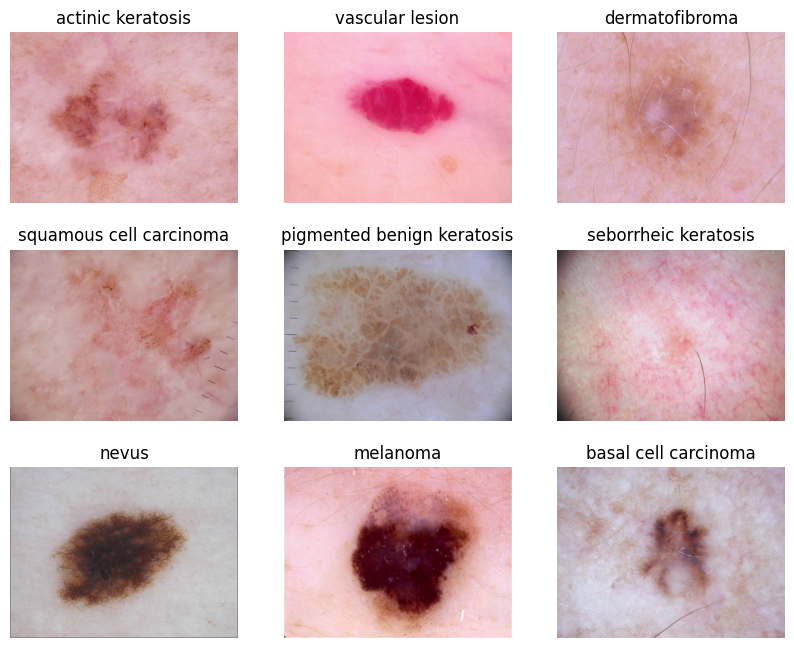

In [38]:
### your code goes here, you can use training or validation data to visualize

fig=plt.figure(figsize=(10,8))
counter=1
for f in data_dir_train.iterdir():
  im=Image.open(next(f.iterdir()))
  plt.subplot(3,3,counter)
  plt.imshow(im)
  plt.title(str(f).split('/')[-1])
  counter+=1
  plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [39]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [40]:
num_classes = 9

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255,input_shape=(180,180,3)),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)

])

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [41]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [42]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 43, 43, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 41, 41, 32)       

### Train the model

In [43]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
281/281 [==============================] - 68s 60ms/step - loss: 1.9443 - accuracy: 0.2449 - val_loss: 1.4525 - val_accuracy: 0.4250
Epoch 2/20
281/281 [==============================] - 4s 15ms/step - loss: 1.3794 - accuracy: 0.4688 - val_loss: 1.3012 - val_accuracy: 0.5109
Epoch 3/20
281/281 [==============================] - 3s 12ms/step - loss: 1.1722 - accuracy: 0.5583 - val_loss: 1.0609 - val_accuracy: 0.6159
Epoch 4/20
281/281 [==============================] - 4s 13ms/step - loss: 0.8859 - accuracy: 0.6758 - val_loss: 0.7993 - val_accuracy: 0.6911
Epoch 5/20
281/281 [==============================] - 4s 13ms/step - loss: 0.6893 - accuracy: 0.7491 - val_loss: 0.7269 - val_accuracy: 0.7370
Epoch 6/20
281/281 [==============================] - 4s 13ms/step - loss: 0.5321 - accuracy: 0.8063 - val_loss: 0.7695 - val_accuracy: 0.7219
Epoch 7/20
281/281 [==============================] - 4s 12ms/step - loss: 0.4540 - accuracy: 0.8363 - val_loss: 0.6143 - val_accuracy: 0.789

### Visualizing training results

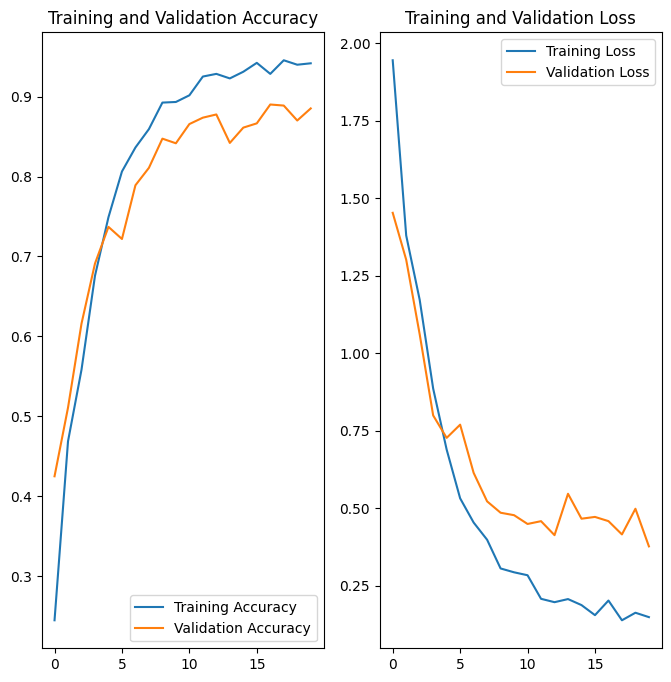

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


####  Write your findings after the model fit, see if there is an evidence of model overfit or underfit

## Observation:

The model is clearly overfitting  - Training accuracy is > 80%, but Testing accuracy falls to less than 60% with each increase in epoch. Similar trend is also observed in Training and Validation loss.

In [46]:
# Strategy 1: Implement Rotation, Zoom and Flip operation on image.
# Strategy 2: Use Drop out layer
# Strategy 3: Create a model with more data


data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

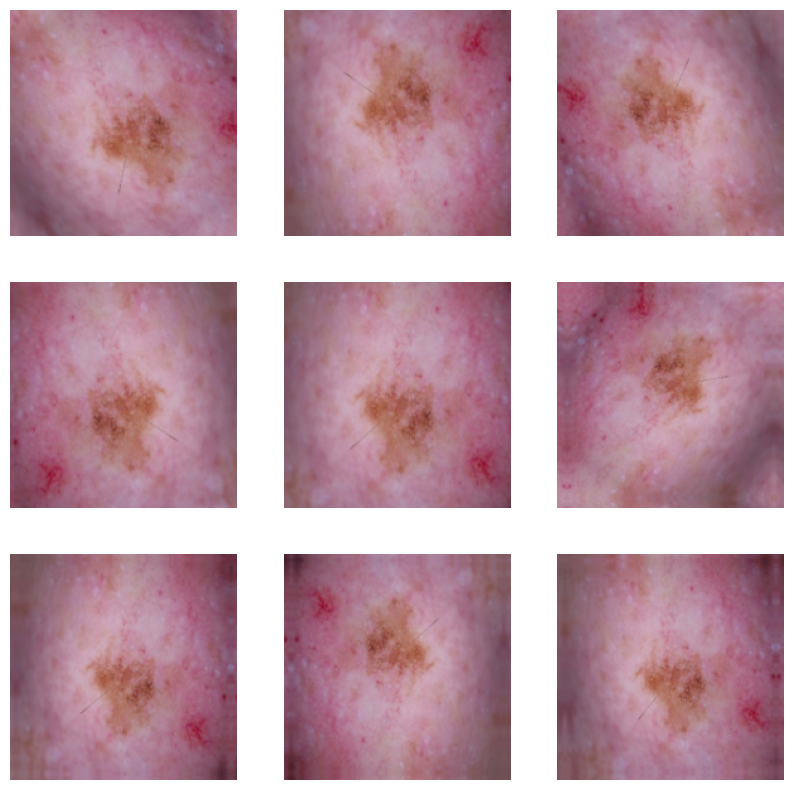

In [47]:
# Visualization of augmentation strategy works for one instance of training image.

for batch,labels in train_ds.take(1):
  im=batch[0]
  im=tf.reshape(im,(1,img_width,img_height,3))

plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(im)[0]
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image.numpy().astype("uint8"))
  plt.axis("off")

### Create the model, compile and train the model


In [48]:
## Adding dropout layer to contain overfitting

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])



### Compiling the model

In [49]:
## Your code goes here

model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [50]:
## Your code goes here, note: train your model for 20 epochs
epochs=20

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs)

Epoch 1/20
281/281 [==============================] - 9s 18ms/step - loss: 1.6940 - accuracy: 0.3440 - val_loss: 1.4200 - val_accuracy: 0.4464
Epoch 2/20
281/281 [==============================] - 5s 19ms/step - loss: 1.4018 - accuracy: 0.4540 - val_loss: 1.3694 - val_accuracy: 0.4771
Epoch 3/20
281/281 [==============================] - 4s 16ms/step - loss: 1.2959 - accuracy: 0.4960 - val_loss: 1.1909 - val_accuracy: 0.5461
Epoch 4/20
281/281 [==============================] - 5s 18ms/step - loss: 1.2383 - accuracy: 0.5192 - val_loss: 1.2418 - val_accuracy: 0.5251
Epoch 5/20
281/281 [==============================] - 5s 17ms/step - loss: 1.1827 - accuracy: 0.5450 - val_loss: 1.2083 - val_accuracy: 0.5389
Epoch 6/20
281/281 [==============================] - 4s 16ms/step - loss: 1.1119 - accuracy: 0.5740 - val_loss: 1.0734 - val_accuracy: 0.6061
Epoch 7/20
281/281 [==============================] - 5s 17ms/step - loss: 1.0782 - accuracy: 0.5808 - val_loss: 1.0524 - val_accuracy: 0.6101

### Visualizing the results

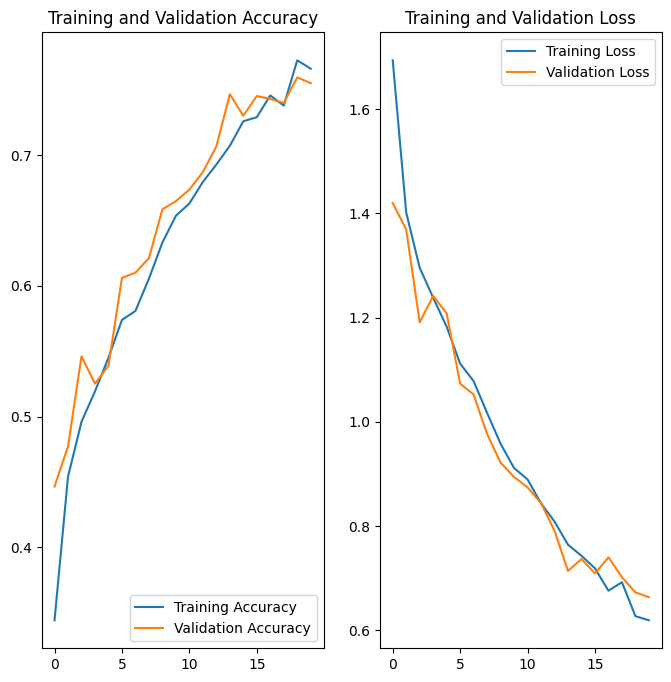

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [52]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

2239


In [53]:

## Your code goes here.
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
dataframe_dict = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
original_df['Label'].value_counts()

Label
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: count, dtype: int64

#### - Which class has the least number of samples?

####   Answer: seborrheic keratosis


#### - Which classes dominate the data in terms proportionate number of samples?

####   Answer: pigmented benign keratosis

**bold text**#### Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [54]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [55]:


path_to_training_dataset=str(data_dir_train)+'/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)



    ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/melanoma_assignment/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AC431D23670>: 100%|██████████| 500/500 [00:25<00:00, 19.70 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/melanoma_assignment/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AC431D5AB30>: 100%|██████████| 500/500 [00:26<00:00, 19.03 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/melanoma_assignment/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7AC43272AE60>: 100%|██████████| 500/500 [00:22<00:00, 21.96 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/melanoma_assignment/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7AC431EDCBB0>: 100%|██████████| 500/500 [01:26<00:00,  5.76 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/melanoma_assignment/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7AC431DBD7B0>: 100%|██████████| 500/500 [01:22<00:00,  6.06 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/melanoma_assignment/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7AC431D23B20>: 100%|██████████| 500/500 [00:20<00:00, 24.86 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/melanoma_assignment/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7AC4BC16C940>: 100%|██████████| 500/500 [00:44<00:00, 11.22 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/melanoma_assignment/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AC43272B0D0>: 100%|██████████| 500/500 [00:24<00:00, 20.16 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/melanoma_assignment/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AC43272BAC0>: 100%|██████████| 500/500 [00:24<00:00, 20.44 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [56]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

13500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [57]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new[:2]

['/content/drive/MyDrive/melanoma_assignment/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027536.jpg_e85193df-1d4f-4834-8760-32e5fc8d016f.jpg',
 '/content/drive/MyDrive/melanoma_assignment/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025953.jpg_1e196c6e-59cc-474a-9e1b-84a1c87b7f6b.jpg']

In [58]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [59]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [60]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df,df2])

In [61]:
new_df['Label'].value_counts()

Label
pigmented benign keratosis    1962
melanoma                      1938
basal cell carcinoma          1876
nevus                         1857
squamous cell carcinoma       1681
vascular lesion               1639
actinic keratosis             1614
dermatofibroma                1595
seborrheic keratosis          1577
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [62]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [63]:
data_dir_train=data_dir_train
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15739 files belonging to 9 classes.
Using 12592 files for training.


#### Create a validation dataset

In [64]:

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15739 files belonging to 9 classes.
Using 3147 files for validation.


#### Create your model without normalization. We shall then create another model with normalization and compare the performance.

In [65]:
## Creating model without normalization

num_classes = 9

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes)
])

In [66]:
## Compiling the code

## your code goes here
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
## Run training - use 50 epochs.
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)# your model fit code

In [ ]:
# Now run model evaluation to check the output

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Now creating a model but with Normalization

In [70]:
## your code goes here

num_classes = 9

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes)
])

#### Compile model (Choose optimizer and loss function appropriately)

In [72]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Train model

In [ ]:
## Your code goes here, use 50 epochs.
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)# your model fit code

Epoch 1/50
394/394 [==============================] - 108s 259ms/step - loss: 1.7549 - accuracy: 0.3976 - val_loss: 1.7895 - val_accuracy: 0.3054
Epoch 2/50
394/394 [==============================] - 105s 262ms/step - loss: 1.3328 - accuracy: 0.4876 - val_loss: 3.5042 - val_accuracy: 0.2504
Epoch 3/50
394/394 [==============================] - 102s 254ms/step - loss: 1.2120 - accuracy: 0.5348 - val_loss: 1.6606 - val_accuracy: 0.4398
Epoch 4/50
394/394 [==============================] - 100s 250ms/step - loss: 1.1450 - accuracy: 0.5588 - val_loss: 1.4790 - val_accuracy: 0.4811
Epoch 5/50
394/394 [==============================] - 101s 250ms/step - loss: 1.0654 - accuracy: 0.5863 - val_loss: 1.4677 - val_accuracy: 0.5068
Epoch 6/50
394/394 [==============================] - 153s 385ms/step - loss: 1.0058 - accuracy: 0.6103 - val_loss: 0.9311 - val_accuracy: 0.6412
Epoch 7/50
394/394 [==============================] - 102s 254ms/step - loss: 0.9582 - accuracy: 0.6351 - val_loss: 1.2401 -

#### Visualize the model results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

####  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



#### Observation:

1. Training with transformation, including more samples and with more epochs resulted in removing overfitting.

2. Model training without normalization has improved Training and Testing accuracy. However, training with 50 epochs training time has increased.

3. Batch Normalization improves accuracy, but does not improve overfitting.